In [1]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, Float, Date
from sqlalchemy.schema import CreateTable
from sqlalchemy.sql import func
import csv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import pandas as pd
import copy
import gmaps
import time
import calendar
from datetime import date, datetime
from sklearn import cross_validation, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# Fill with a postgres db's details that you have access to
db_name = ""
db_host = ""
db_username = ""
db_password = ""
gmaps.configure(api_key="")

%matplotlib inline

# MAKE SURE THAT YOU HAVE INSTALLED GMAPS JUPYTER EXTENSION
# jupyter nbextension enable --py gmaps

import warnings; warnings.simplefilter('ignore')

from IPython.display import display, HTML
display(HTML(data="""<style> div#notebook-container { width: 90%; } </style> """))

/Users/Bruce/Desktop/env_test/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Setting my Declarative Base for SQLAlchemy

In [2]:
Base = declarative_base()

### My Model Class

In [3]:
class HouseDataTable(Base):
    __tablename__ = 'HouseDataTable'

    reference_id = Column(Integer, primary_key=True, autoincrement=True,
                          nullable=False)
    id = Column(Float)
    ts = Column(Date)
    price = Column(Float, nullable=False)
    bedrooms = Column(Float)
    bathrooms = Column(Float)
    sqft_living = Column(Float)
    sqft_lot = Column(Float)
    floors = Column(Float)
    waterfront = Column(Float)
    view = Column(Float)
    condition = Column(Float)
    grade = Column(Float)
    sqft_above = Column(Float)
    sqft_basement = Column(Float)
    yr_built = Column(Float)
    yr_renovated = Column(Float)
    zipcode = Column(Float)
    lat = Column(Float)
    long = Column(Float)
    sqft_living15 = Column(Float)
    sqft_lot15 = Column(Float)

    def __init__(self, **kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])

    def __repr__(self):
        return self.__str__()


### My ETL class

#### for importing and querying

In [4]:
class ETL:
    def __init__(self):

        self.engine = create_engine("postgresql+psycopg2://%s:%s@%s/%s" % (
            db_username, db_password, db_host, db_name))
        self.engine.connect()
        Session = sessionmaker(bind=self.engine)
        self.session = Session()

    def import_data(self, filepath):
        with open(filepath, "r") as infile:
            reader = csv.reader(infile)

            columns = list(HouseDataTable.__table__.columns)
            del columns[0]
            columnMap = {str(y).replace("HouseDataTable.", ""): x for x, y in enumerate(columns)}

            iter = 0
            items_to_add_to_db = []
            for row in reader:
                if iter > 0:
                    new_object_dict = {x:float(row[columnMap[x]]) 
                                       for x in columnMap
                                       if "T" not in row[columnMap[x]]}
                    new_object_dict["ts"] = "%s-%s-%s" % (row[1][:4], row[1][4:6], row[1][6:8])
                    items_to_add_to_db.append(HouseDataTable(**new_object_dict))
                iter += 1

        print "Committing %s items to db" % (len(items_to_add_to_db))
        self.session.bulk_save_objects(items_to_add_to_db)
        self.session.commit()
        self.session.flush()

In [5]:
print "SQL for creating table HouseDataTable = "
print(CreateTable(HouseDataTable.__table__))

ETL_obj = ETL()
Base.metadata.create_all(ETL_obj.engine)
print "Adding data from csv file"
ETL_obj.import_data("/Users/Bruce/Desktop/kc_house_data.csv")

SQL for creating table HouseDataTable = 

CREATE TABLE "HouseDataTable" (
	reference_id INTEGER NOT NULL, 
	id FLOAT, 
	ts DATE, 
	price FLOAT NOT NULL, 
	bedrooms FLOAT, 
	bathrooms FLOAT, 
	sqft_living FLOAT, 
	sqft_lot FLOAT, 
	floors FLOAT, 
	waterfront FLOAT, 
	view FLOAT, 
	condition FLOAT, 
	grade FLOAT, 
	sqft_above FLOAT, 
	sqft_basement FLOAT, 
	yr_built FLOAT, 
	yr_renovated FLOAT, 
	zipcode FLOAT, 
	lat FLOAT, 
	long FLOAT, 
	sqft_living15 FLOAT, 
	sqft_lot15 FLOAT, 
	PRIMARY KEY (reference_id)
)


Adding data from csv file


### Average price per bed & bath

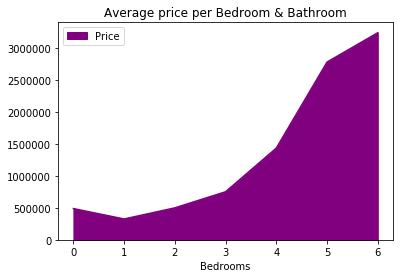

In [6]:
average_price_per_bed_bath = ETL_obj.session.query(HouseDataTable.bedrooms, HouseDataTable.bathrooms,HouseDataTable.price).all()
average_price_per_bed_bath_dataframe = pd.DataFrame(average_price_per_bed_bath, columns=["Bedrooms", "Bathrooms", "Price"])

average_price_per_bed_bath_dataframe["Bedrooms"] = [int(x) for x in average_price_per_bed_bath_dataframe["Bedrooms"]]
average_price_per_bed_bath_dataframe["Bathrooms"] = [int(x) for x in average_price_per_bed_bath_dataframe["Bathrooms"]]

same_number_bed_bath = average_price_per_bed_bath_dataframe[average_price_per_bed_bath_dataframe["Bedrooms"] == average_price_per_bed_bath_dataframe["Bathrooms"]].sort_values("Bedrooms")
same_number_bed_bath = pd.DataFrame(same_number_bed_bath.groupby("Bedrooms").Price.mean()).reset_index()

same_number_bed_bath.sort_values("Bedrooms").plot(y="Price", x="Bedrooms", kind="area", title="Average price per Bedroom & Bathroom", color="purple")

Here we will assume that a property having 0 bedrooms and 0 bathrooms is a studio flat that has everything in one room. From this chart we can see that the the average price of a property skyrockets after 3 bedrooms and bathrooms. 

However based on the histograms below this could be due to a small sample size of these large properties. 

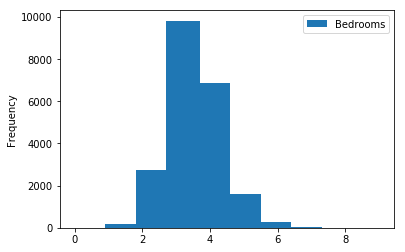

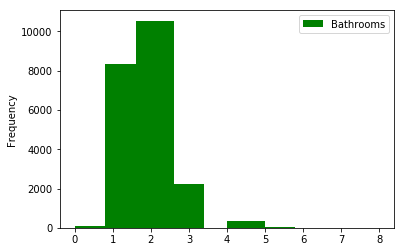

In [7]:
average_price_per_bed_bath_dataframe[average_price_per_bed_bath_dataframe["Bedrooms"] < 10].plot(y = "Bedrooms", kind="hist", width=1)
average_price_per_bed_bath_dataframe[average_price_per_bed_bath_dataframe["Bedrooms"] < 10].plot(y = "Bathrooms", kind="hist", color = 'green', width=1)

In [8]:
all_fields_query = ETL_obj.session.query(HouseDataTable)
raw_df = pd.read_sql(all_fields_query.statement, all_fields_query.session.bind)
correlation_df = raw_df.drop(['reference_id', "id", "ts"], axis=1)

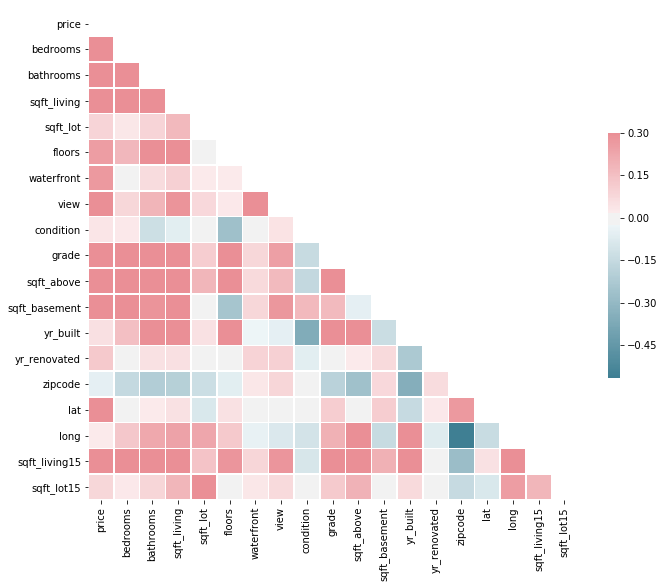

In [9]:
corr = correlation_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

After analysing the correlation between other variables and price we can see many weak level correlations between each of the numberical variables. The three extra factors that I think would be great to segment on price would be:
<strong>
<ul> 
<li>Years since last renovated</li>
<li>Years since the property was built</li>
<li>Which time of year the property was being sold (January, February etc.)</li>
</ul>
</strong>

## Outliers

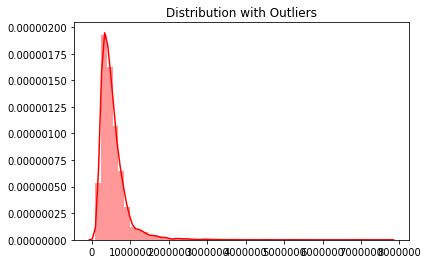

Mean = 541314.0239670569
Standard deviation = 367179.5914050665
5th Percentile = 210000.0
70th Percentile = 600000.0


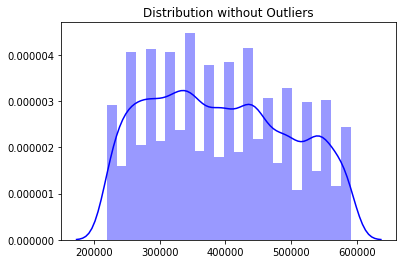

In [10]:
# round to the nearest 10k
prices_dist = [round(x/10000)*10000 for x in raw_df["price"]]
sns.distplot(prices_dist, color = "red").set_title("Distribution with Outliers")
plt.show()

np_array = np.array(prices_dist)
q5, q70 = np.percentile(np_array, [5 ,70])
print "Mean = %s" % np_array.mean()
print "Standard deviation = %s" % np_array.std()
print "5th Percentile = %s" % q5
print "70th Percentile = %s" % q70

prices_dist_no_outliers = np_array[(np_array<q70) & (np_array>q5)]

sns.distplot(prices_dist_no_outliers, color="blue").set_title("Distribution without Outliers")
plt.show()

Since we have such a positively skewed distribution here, taking everything X standard deviations away from the mean as outliers would allow outliers on the lower end of the scale to remain,. This would shrink the long right tail of our distribution though.

For this type of distribution it would be better to take anything that is <strong>between the 5th and 70th percentile</strong> and assume the rest are outliers. This is because the higher prices in the tail will cause the model to overfit more than the higher amount of price points at the bottom of the range and the resulting shape of our probability density function chart.

Below is a variable containing a list of outliers

In [11]:
list_of_outliers = raw_df[(raw_df["price"] > q70) | (raw_df["price"] < q5)]["id"].astype(int).tolist()

## Awesome Visualisation & Insight

In [12]:
map_data = raw_df.copy(deep=True)
map_data = map_data[~map_data["reference_id"].isin(list_of_outliers)]
map_data["ts"] = [x.month for x in map_data["ts"]]

map_data = pd.DataFrame(map_data.groupby(["lat", "long", "ts"]).price.mean()).reset_index().sort_values("ts")
map_data_months = map_data["ts"].unique()

locations_dict = {}
for ts in map_data_months:
    long_lat_pairs = [tuple(x) for x in map_data[map_data["ts"] == ts][["lat", "long"]].values]
    prices = map_data[map_data["ts"] == ts]["price"].tolist()
    locations_dict[ts] = {"locations":long_lat_pairs, "prices":prices}
    
average_long  = map_data["long"].mean()
average_lat = map_data["lat"].mean()
max_price = map_data["price"].max()
min_price = map_data["price"].min()

In [13]:
# This is an animation heatmap to show how the average price per location changes over the year

# Make sure you have run the below command before opening jupyter notebook and rerun the script
# jupyter nbextension enable --py gmaps

class HeatmapAnimation(object):
    
    def __init__(self, datasets):
        self._datasets = datasets
        self._figure = gmaps.figure(center=(average_lat, average_long), zoom_level=10)
        self._heatmap = gmaps.heatmap_layer(datasets[1]["locations"])
        self._heatmap.weights = datasets[1]["prices"]
        self._figure.add_layer(self._heatmap)
        
    def render(self):
        return display(self._figure)
    
    def start_animation(self):
        for field in self._datasets:
            print "In %s sales look like this ..." % calendar.month_name[field]
            self._render_current_dataset(field)
            time.sleep(1)
    
    def _render_current_dataset(self, month):
        self._heatmap.locations = self._datasets[month]["locations"]
        self._heatmap.weights = self._datasets[month]["prices"]


animation = HeatmapAnimation(locations_dict)
animation.render()
animation.start_animation()
        

Figure(layout=FigureLayout(height=u'420px'))

In January sales look like this ...
In February sales look like this ...
In March sales look like this ...
In April sales look like this ...
In May sales look like this ...
In June sales look like this ...
In July sales look like this ...
In August sales look like this ...
In September sales look like this ...
In October sales look like this ...
In November sales look like this ...
In December sales look like this ...


From the chart above you can see that the <strong>month of year has a big impact on the volume of sales but not necessarily the average price.</strong>

<ol>
    <li>The proximity of the property to the bay makes a massive difference to the price, properties in the bay on the northern part of the peninsula are the most expensive</li>
    <li>Months such as April and September have the most volume of property sales, however as you can see below, this only results in a higher average property price in April. </li>
</ol>

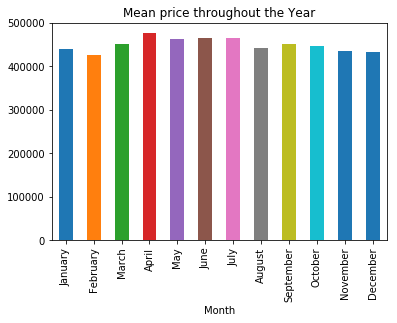

In [14]:
avg_price_month = raw_df[["ts", "price"]]
avg_price_month["ts"] = [x.month for x in avg_price_month["ts"]]
avg_price_month["Month"] = [calendar.month_name[x] for x in avg_price_month["ts"]]
avg_price_month = pd.DataFrame(avg_price_month.groupby(["ts", "Month"]).price.median()).reset_index()

avg_price_month.plot(x="Month", y="price", kind="bar", title="Mean price throughout the Year", legend=False)

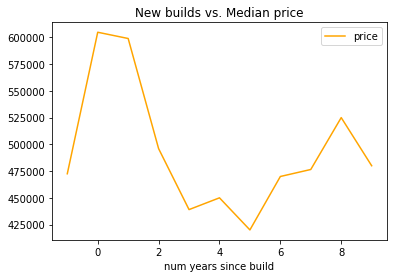

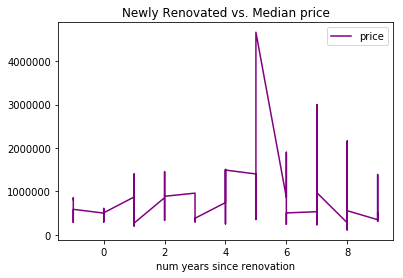

In [15]:
# time since rennovation
date_comparison_metrics = raw_df.copy(deep=True)

date_comparison_metrics["year"] = [float(x.year) for x in date_comparison_metrics["ts"]]
date_comparison_metrics["num years since build"] = date_comparison_metrics["year"] - date_comparison_metrics["yr_built"]
date_comparison_metrics["num years since renovation"] = date_comparison_metrics["year"] - date_comparison_metrics["yr_renovated"]

date_comparison_metrics["num years since renovation"] = date_comparison_metrics["num years since renovation"].replace([2014.0, 2015.0], 0)
date_comparison_metrics_group = pd.DataFrame(date_comparison_metrics.groupby(["num years since build", "num years since renovation"]).price.median()).reset_index()

date_comparison_metrics_group[date_comparison_metrics_group["num years since build"]< 10].plot(x="num years since build", y= "price", color="orange", title="New builds vs. Median price" )
date_comparison_metrics_group[date_comparison_metrics_group["num years since renovation"]< 10].sort_values("num years since renovation").plot(x="num years since renovation", y= "price", color="purple", title="Newly Renovated vs. Median price" )

<h5>So What?</h5>
<h6>Volumes of sales & property prices based on the time of year</h6>
From this insight, there are many things we can derive from the data. Based on the charts above, there little sense in holding onto a property through certain months of the year to drive the price up based on the time of year that you are selling. However it would be reasonable to assume that a given property might take longer to sell at certain time of the year because of the increased demand from other properties at the same price point.

<h6>Recency of Renovation and build</h6>
We have also learnt here that, buying <strong>offplan (before the property has been built) results in a cheaper property on average</strong> and <strong>new properties have a very high value.</strong> There is also a <strong>premium for properties that are planned to be rennovated.</strong> This shows us some ways to get a cheaper new property or make some money on a property we could be trying to sell ourselves.


## Modelling

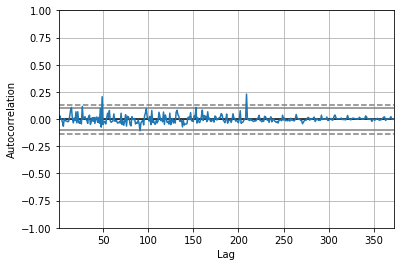

In [16]:
arima_test = raw_df[["ts", "price"]].sort_values("ts")
arima_test = pd.DataFrame(arima_test.groupby("ts").price.median()).reset_index()

autocorrelation_plot(arima_test.set_index('ts'))
plt.show()

As you can see here, there is no significance from the lags in the data. This rules out a simple ARIMA model to take into account the seasonality that we saw in the map above.

#### Linear regression model

In [17]:
# Cleaning and splitting Data
model_learning = date_comparison_metrics.copy(deep=True)
model_learning_train = model_learning.drop(["price", "id", "reference_id", "long", "lat", "zipcode", "yr_built", "yr_renovated", "sqft_living15", "sqft_lot15"], axis =1) 
model_learning_train["ts"] = [x.month for x in model_learning_train["ts"]]

# Normalisation
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(model_learning_train)
model_learning_train = pd.DataFrame(x_scaled)

model_learning_test = model_learning["price"]
X_train, X_test, y_train, y_test = train_test_split(model_learning_train, model_learning_test, test_size=0.2)

In [18]:
regr = linear_model.LinearRegression()

scores = cross_validation.cross_val_score(regr, X_train, y_train, scoring='r2', cv=15, n_jobs = -1, verbose=True)
print "r^2 value achieved through Cross Validation = %s" % max(scores)

regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
print "r^2 value achieved on test data = %s" % r2_score(y_test, predictions)

r^2 value achieved through Cross Validation = 0.67856168102789
r^2 value achieved on test data = 0.6537712246122712


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


### Model explanation

Here I have chosen a simple evaluation metric for a simple model. To create it and make it work I have
<ul>
    <li>Removed most of the non numeric fields</li>
    <li>Casted the rest of the non numeric fields to a numeric type</li>
    <li>Min-Max normalised it all to remove overfitting from the year values</li>
</ul>

This has <strong>achieved ~70% r^2 score</strong>.

If I has more time, other things I would look at are:

# Programming

In [19]:
# using pandas and dictionary objects
def create_dictionary(dataframe):
    dict_df = dataframe.to_dict(orient="records") 
    return_array = []
    for x in dict_df:
        obj = {"id": x["id"], "data":{"price":x["price"], "date":x["ts"], "zipcode":x["zipcode"]}}
        return_array.append(obj)
    return return_array

times = []
num_items = []
for x in range(len(raw_df)/1000):
    then = datetime.now()
    num_items.append((x*1000))
    dictionary_obj = create_dictionary(raw_df.loc[:(x*1000),["id", "price", "zipcode", "ts"]])
    times.append((datetime.now() - then).microseconds/1000)

Max time taken = 812 milliseconds


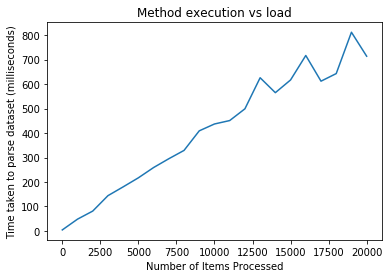

In [20]:
print "Max time taken = %s milliseconds" % max(times)
plt.plot(num_items, times)
plt.xlabel('Number of Items Processed')
plt.ylabel('Time taken to parse dataset (milliseconds)')
plt.title('Method execution vs load')
plt.show()

This way of doing it takes full advantage of the numpy arrays included inside of the pandas dataframe which means that it runs in around 850 milliseconds.

The chart above shows that the method's performance will grow linearly with more data representing a O(N) orders of growth.